# Numpy-CNN

A numpy-only implementation of a Convolutional Neural Network, from the ground up.

### Forward operations

In [1]:
'''
Description: forward operations for a convolutional neural network

'''
import numpy as np


#####################################################
################ Forward Operations #################
#####################################################


def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f,out_dim,out_dim))
    
    # convolve the filter over every part of the image, adding the bias at each step. 
    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return out

def maxpool(image, f=2, s=2):
    '''
    Downsample `image` using kernel size `f` and stride `s`
    '''
    n_c, h_prev, w_prev = image.shape
    
    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1
    
    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled

def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)

def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

### Backpropagation through a Convolutional Layer and Max Pooling Layer 

In [2]:
import numpy as np


#####################################################
############### Backward Operations #################
#####################################################
        
def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias



def maxpoolBackward(dpool, orig, f, s):
    '''
    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.
    '''
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

# Implementing Convolutional Neural Networks in PyTorch

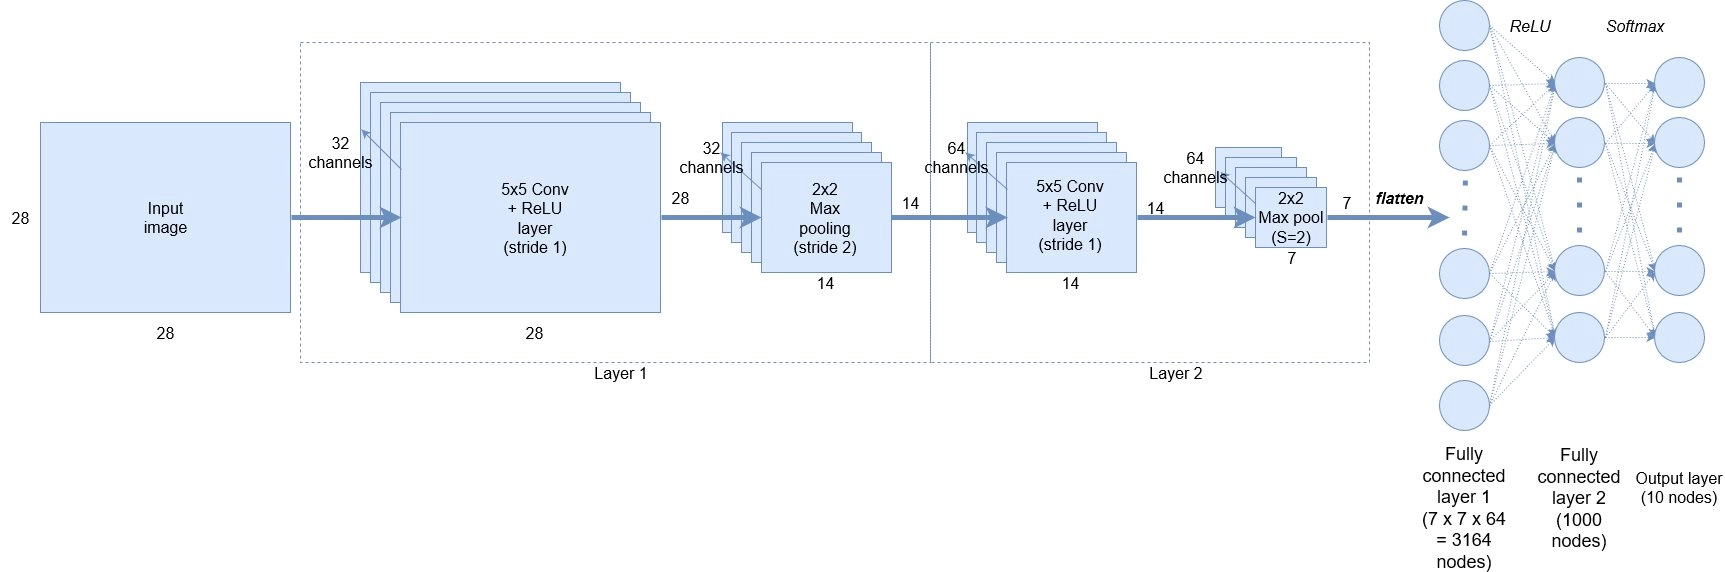

First up, we can see that the input images will be 28 x 28 pixel greyscale representations of digits. The first layer will consist of 32 channels of 5 x 5 convolutional filters + a ReLU activation, followed by 2 x 2 max pooling down-sampling with a stride of 2 (this gives a 14 x 14 output). In the next layer, we have the 14 x 14 output of layer 1 being scanned again with 64 channels of 5 x 5 convolutional filters and a final 2 x 2 max pooling (stride = 2) down-sampling to produce a 7 x 7 output of layer 2.

After the convolutional part of the network, there will be a flatten operation which creates 7 x 7 x 64 = 3164 nodes, an intermediate layer of 1000 fully connected nodes and a softmax operation over the 10 output nodes to produce class probabilities. These layers represent the output classifier.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np

### Loading the dataset

PyTorch has an integrated MNIST dataset (in the torchvision package) which we can use via the DataLoader functionality.

In [ ]:
# Hyperparameters
num_epochs = 6
num_classes = 10
batch_size = 100
learning_rate = 0.001

# Adjust Path for your Directory
DATA_PATH = "C:\\Users\eljan\Downloads\MNISTData"
MODEL_STORE_PATH = "C:\\Users\eljan\Downloads\Model"

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Creating Model

In [ ]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = ConvNet()

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Model

In [ ]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

### Testing Model

In [9]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)


Using downloaded and verified file: C:\Users\eljan\Downloads\MNISTData\MNIST\raw\train-images-idx3-ubyte.gz
Extracting C:\Users\eljan\Downloads\MNISTData\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\eljan\Downloads\MNISTData\MNIST\raw



Extracting C:\Users\eljan\Downloads\MNISTData\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\eljan\Downloads\MNISTData\MNIST\raw


Extracting C:\Users\eljan\Downloads\MNISTData\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\eljan\Downloads\MNISTData\MNIST\raw


Extracting C:\Users\eljan\Downloads\MNISTData\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\eljan\Downloads\MNISTData\MNIST\raw
Processing...
Done!




Epoch [1/6], Step [100/600], Loss: 0.2910, Accuracy: 87.00%
Epoch [1/6], Step [200/600], Loss: 0.0747, Accuracy: 98.00%
Epoch [1/6], Step [300/600], Loss: 0.0710, Accuracy: 99.00%
Epoch [1/6], Step [400/600], Loss: 0.1019, Accuracy: 96.00%
Epoch [1/6], Step [500/600], Loss: 0.0964, Accuracy: 95.00%
Epoch [1/6], Step [600/600], Loss: 0.0911, Accuracy: 97.00%
Epoch [2/6], Step [100/600], Loss: 0.0223, Accuracy: 100.00%
Epoch [2/6], Step [200/600], Loss: 0.0956, Accuracy: 97.00%
Epoch [2/6], Step [300/600], Loss: 0.0803, Accuracy: 97.00%
Epoch [2/6], Step [400/600], Loss: 0.0079, Accuracy: 100.00%
Epoch [2/6], Step [500/600], Loss: 0.1349, Accuracy: 97.00%
Epoch [2/6], Step [600/600], Loss: 0.0621, Accuracy: 97.00%
Epoch [3/6], Step [100/600], Loss: 0.0612, Accuracy: 99.00%
Epoch [3/6], Step [200/600], Loss: 0.0788, Accuracy: 97.00%
Epoc

As can be observed, the network quite rapidly achieves a high degree of accuracy on the training set, and the test set accuracy, after 6 epochs, arrives at 99% – not bad! Certainly better than the accuracy achieved in basic fully connected neural networks.

In [11]:
show(p)

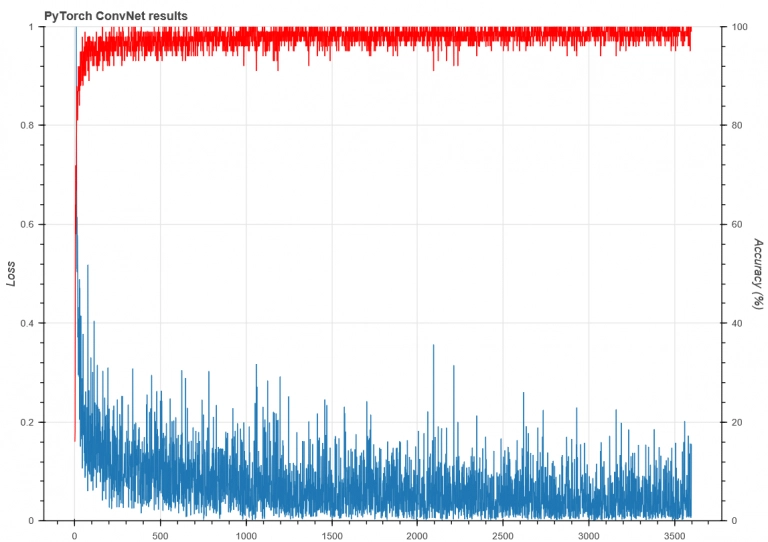